## Introdução

Aqui irei realizar a etapa de Feature Engineering na base de dados `credit_card_balance`.

Esta etapa está dividida em kernels diferentes devido o consumo de memória para carregar e manipular as bases.

Os procedimentos realizados nas outras bases podem ser encontrados nos arquivos `02_feat_eng_<nome-da-base>.ipynb`

O objetivo desta etapa consiste, principalmente, em criar variáveis (`book de variáveis`). Ao criar novas variáveis com base nas variáveis existentes, é possível capturar informações adicionais que podem não estar explicitamente presentes nos dados originais.

Devido o volume de dados, optei por utilizar o PySpark em conjunto com o SparkSQL para as operações a seguir.

* Sobre os Dados

A base `credit_card_balance` possui informações mensais sobre saldos de cartões de crédito do cliente.

Segundo os Metadados disponibilizados, essas são as informações contidas aqui:

`SK_ID_PREV`: ID do crédito anterior. (Um crédito em nossa amostra pode ter 0, 1, 2 ou mais créditos anteriores no Crédito Habitacional). Será utilizada como PK para conectarmos à base `previous_application`, conforme a esquematização abaixo.

`SK_ID_CURR`: ID do empréstimo.

`MONTHS_BALANCE`: Mês do saldo em relação à data da aplicação (-1 significa a data de saldo mais recente). Essa aqui será nossa chave temporal.

`AMT_BALANCE`: Saldo durante o mês do crédito anterior.

`AMT_CREDIT_LIMIT_ACTUAL`: Limite do cartão de crédito durante o mês do crédito anterior.

`AMT_DRAWINGS_ATM_CURRENT`: Valor sacado no caixa eletrônico durante o mês do crédito anterior.

`AMT_DRAWINGS_CURRENT`: Valor sacado durante o mês do crédito anterior.

`AMT_DRAWINGS_OTHER_CURRENT`: Valor de outros saques durante o mês do crédito anterior.

`AMT_DRAWINGS_POS_CURRENT`: Valor sacado ou compras realizadas durante o mês do crédito anterior.

`AMT_INST_MIN_REGULARITY`: Parcela mínima para este mês do crédito anterior.

`AMT_PAYMENT_CURRENT`: Quanto o cliente pagou durante o mês no crédito anterior.

`AMT_PAYMENT_TOTAL_CURRENT`: Quanto o cliente pagou durante o mês no total no crédito anterior.

`AMT_RECEIVABLE_PRINCIPAL`: Valor recebível pelo principal do crédito anterior.

`AMT_RECIVABLE`: Valor a receber no crédito anterior.

`AMT_TOTAL_RECEIVABLE`: Valor total a receber no crédito anterior.

`CNT_DRAWINGS_ATM_CURRENT`: Número de saques no caixa eletrônico durante este mês no crédito anterior.

`CNT_DRAWINGS_CURRENT`: Número de saques durante este mês no crédito anterior.

`CNT_DRAWINGS_OTHER_CURRENT`: Número de outros saques durante este mês no crédito anterior.

`CNT_DRAWINGS_POS_CURRENT`: Número de saques para compras durante este mês no crédito anterior.

`CNT_INSTALMENT_MATURE_CUM`: Número de parcelas pagas no crédito anterior.

`NAME_CONTRACT_STATUS`: Status do contrato (assinado ativo, etc.) no crédito anterior.

`SK_DPD`: DPD (Dias de atraso) durante o mês no crédito anterior.

`SK_DPD_DEF`: DPD (Dias de atraso) durante o mês com tolerância (dívidas com baixos valores de empréstimo são ignoradas) do crédito anterior.

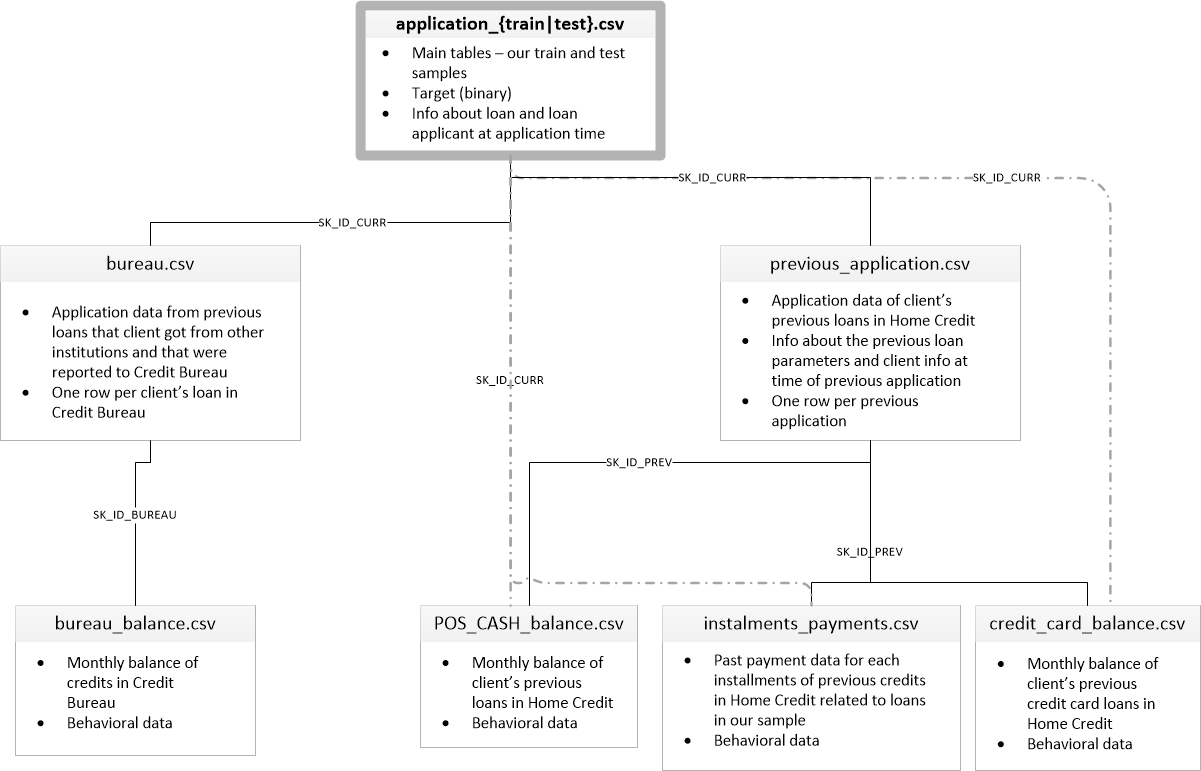

## Utils

* Importando as bibliotecas que irei utilizar

In [1]:
import os
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import when,min, max, sum, round, col, median
spark = SparkSession.builder \
    .appName("FeatureEng") \
    .config("spark.executor.memory", "14g") \
    .config("spark.driver.memory", "14g") \
    .getOrCreate()
from warnings import filterwarnings
filterwarnings('ignore')

## Feature Engineering - Credit Card Balance

### 1. Carregamento e Informações Gerais

* Carregando e Visualizando os dados utilizando o PySpark

In [2]:
credit_balance = spark.read.csv('./DATASETS/credit_card_balance.csv', header= True, inferSchema= True)

In [3]:
credit_balance.show(n=5, truncate= False)

+----------+----------+--------------+-----------+-----------------------+------------------------+--------------------+--------------------------+------------------------+-----------------------+-------------------+-------------------------+------------------------+-------------+--------------------+------------------------+--------------------+--------------------------+------------------------+-------------------------+--------------------+------+----------+
|SK_ID_PREV|SK_ID_CURR|MONTHS_BALANCE|AMT_BALANCE|AMT_CREDIT_LIMIT_ACTUAL|AMT_DRAWINGS_ATM_CURRENT|AMT_DRAWINGS_CURRENT|AMT_DRAWINGS_OTHER_CURRENT|AMT_DRAWINGS_POS_CURRENT|AMT_INST_MIN_REGULARITY|AMT_PAYMENT_CURRENT|AMT_PAYMENT_TOTAL_CURRENT|AMT_RECEIVABLE_PRINCIPAL|AMT_RECIVABLE|AMT_TOTAL_RECEIVABLE|CNT_DRAWINGS_ATM_CURRENT|CNT_DRAWINGS_CURRENT|CNT_DRAWINGS_OTHER_CURRENT|CNT_DRAWINGS_POS_CURRENT|CNT_INSTALMENT_MATURE_CUM|NAME_CONTRACT_STATUS|SK_DPD|SK_DPD_DEF|
+----------+----------+--------------+-----------+------------------

* Verificando as dimensões (Linhas x Colunas)

In [4]:
(credit_balance.count(), len(credit_balance.columns))

(3840312, 23)

* Checando se existem linhas duplicadas

In [5]:
credit_balance.dropDuplicates().count() - credit_balance.count()

0

### 2. Criação de Flags Temporais

In [3]:
# Criando uma View
credit_balance.createOrReplaceTempView('credit_balance')

temp01 = spark.sql("""
SELECT
    *,
        CASE
            WHEN MONTHS_BALANCE >= -3 THEN 1
        ELSE 0
    END AS FL_U3M,
        CASE
            WHEN MONTHS_BALANCE >= -6 THEN 1
        ELSE 0
    END AS FL_U6M,
        CASE
            WHEN MONTHS_BALANCE >= -9 THEN 1
        ELSE 0
    END AS FL_U9M,
        CASE
            WHEN MONTHS_BALANCE >= -12 THEN 1
        ELSE 0
    END AS FL_U12M
FROM
    credit_balance
ORDER BY
    `SK_ID_PREV`;
""")

temp01.createOrReplaceTempView('temp01')

### 3. Criação das Flags das Variáveis Categóricas

* Esta base possui apenas uma coluna categórica: `NAME_CONTRACT_STATUS`, que indica o status do contrato. Irei criar flags para indicar qual valor único de contrato um dado registro se refere.

In [4]:
# Lista para armazenar as colunas criadas
flags = []

# Pegando todas as colunas categoricas da tabela
cat_cols = [cat_col[0] for cat_col in temp01.dtypes if cat_col[1] == 'string']

# Gerando as colunas Flag
for cat_col in cat_cols:
    unique_vals = [col[0] for col in temp01.select(cat_col).distinct().collect()]

    for unique_val in unique_vals:
        flags.append(when(col(cat_col) == unique_val, 1).otherwise(0).alias(f'FL_CAT_{cat_col}_{unique_val.upper().replace(" ", "_")}'))

* Realizando o Unpacking e Criando a Tabela

In [5]:
# temp02 = temp01.select("*", *flags)
temp02 = temp01

### 4. Criação das Variáveis (Agrupadas)

* Filtrando as colunas que serão agregadas

In [6]:
# Selecionando as variáveis que serão agregadas (exceto Flags e IDs)
agg_cols = [col for col in temp02.columns if ("FL_" not in col) & ("SK_ID" not in col)]

# Removendo a Coluna de Janela Temporal
agg_cols.remove('MONTHS_BALANCE')

# Removendo as colunas categóricas que tiveram flags criadas
for cat_col in cat_cols:
    agg_cols.remove(cat_col)

* Criando as novas variáveis e agrupando os dados

In [7]:
flags_temporais = ['FL_U3M', 'FL_U6M', 'FL_U9M','FL_U12M']

flags_categoricas = [col for col in temp02.columns if 'FL_CAT_' in col]

#### 4.1 Usando Apenas Flags Temporais

In [8]:
new_cols = []

for flag_temp in flags_temporais:

    for agg_col in agg_cols:

        if 'DPD' in agg_col:
            new_cols.append(round(max(when(col(flag_temp) == 1, col(agg_col))),2).alias(f"QT_MAX_{agg_col}_{flag_temp}_CREDITCARDBALANCE"))
            new_cols.append(round(min(when(col(flag_temp) == 1, col(agg_col))),2).alias(f"QT_MIN_{agg_col}_{flag_temp}_CREDITCARDBALANCE"))
        else:
            new_cols.append(round(max(when(col(flag_temp) == 1, col(agg_col))),2).alias(f"VL_MAX_{agg_col}_{flag_temp}_CREDITCARDBALANCE"))
            new_cols.append(round(min(when(col(flag_temp) == 1, col(agg_col))),2).alias(f"VL_MIN_{agg_col}_{flag_temp}_CREDITCARDBALANCE"))
            new_cols.append(round(sum(when(col(flag_temp) == 1, col(agg_col))),2).alias(f"VL_SUM_{agg_col}_{flag_temp}_CREDITCARDBALANCE"))
            new_cols.append(round(median(when(col(flag_temp) == 1, col(agg_col))),2).alias(f"VL_MD_{agg_col}_{flag_temp}_CREDITCARDBALANCE"))

new_cols = tuple(new_cols)

temp03 = temp02.groupBy("SK_ID_PREV").agg(*new_cols).orderBy("SK_ID_PREV")

In [15]:
temp03 = temp03.repartition(1)
temp03.write.mode("overwrite").option("compression", "gzip").parquet("./VARS/CREDIT_CARD_BALANCE/FL_TEMPORAL")

In [9]:
print('Quantidade de Vars. Criadas: ', len(temp03.columns))

Quantidade de Vars. Criadas:  289


In [22]:
# Liberando Memória
temp03 = None
del(temp03)

#### 4.2 Usando Apenas Flags Categóricas

In [15]:
# new_cols = []

# for cat_flag in flags_categoricas:
#     for agg_col in agg_cols:

#         if 'DPD' in agg_col:
#             new_cols.append(round(max(when(col(cat_flag) == 1, col(agg_col))),2).alias(f"QT_MAX_{agg_col}_{cat_flag}".replace("FL_CAT_", '')))
#             new_cols.append(round(min(when(col(cat_flag) == 1, col(agg_col))),2).alias(f"QT_MIN_{agg_col}_{cat_flag}".replace("FL_CAT_", '')))
#         else:
#             new_cols.append(round(max(when(col(cat_flag) == 1, col(agg_col))),2).alias(f"VL_MAX_{agg_col}_{cat_flag}".replace("FL_CAT_", '')))
#             new_cols.append(round(min(when(col(cat_flag) == 1, col(agg_col))),2).alias(f"VL_MIN_{agg_col}_{cat_flag}".replace("FL_CAT_", '')))
#             new_cols.append(round(sum(when(col(cat_flag) == 1, col(agg_col))),2).alias(f"VL_SUM_{agg_col}_{cat_flag}".replace("FL_CAT_", '')))
#             new_cols.append(round(median(when(col(cat_flag) == 1, col(agg_col))),2).alias(f"VL_MD_{agg_col}_{cat_flag}".replace("FL_CAT_", '')))

# new_cols = tuple(new_cols)

# temp04 = temp02.groupBy("SK_ID_PREV").agg(*new_cols).orderBy("SK_ID_PREV")

In [16]:
# temp04 = temp04.repartition(1)
# temp04.write.mode("overwrite").option("compression", "gzip").parquet("./VARS/CREDIT_CARD_BALANCE/FL_CATEGORICAS")

In [17]:
# print('Quantidade de Vars. Criadas: ', len(temp04.columns))

Quantidade de Vars. Criadas:  505


In [18]:
# # Liberando Memória
# temp04 = None
# del(temp04)

#### 4.3 Usando Flags Temporais + Categóricas

In [19]:
# new_cols = []

# for flag_temp in flags_temporais:
#     for cat_flag in flags_categoricas:
#         for agg_col in agg_cols:
#             if 'DPD' in agg_col:
#                 new_cols.append(round(max(when((col(cat_flag) == 1) & (col(flag_temp) == 1), col(agg_col))),2).alias(f"QT_MAX_{agg_col}_{cat_flag}_{flag_temp}_{flag_temp}".replace("FL_CAT_", '').replace("FL_", "")))
#                 new_cols.append(round(min(when((col(cat_flag) == 1) & (col(flag_temp) == 1), col(agg_col))),2).alias(f"QT_MIN_{agg_col}_{cat_flag}_{flag_temp}".replace("FL_CAT_", '').replace("FL_", "")))
#             else:
#                 new_cols.append(round(max(when((col(cat_flag) == 1) & (col(flag_temp) == 1), col(agg_col))),2).alias(f"VL_MAX_{agg_col}_{cat_flag}_{flag_temp}".replace("FL_CAT_", '').replace("FL_", "")))
#                 new_cols.append(round(min(when((col(cat_flag) == 1) & (col(flag_temp) == 1), col(agg_col))),2).alias(f"VL_MIN_{agg_col}_{cat_flag}_{flag_temp}".replace("FL_CAT_", '').replace("FL_", "")))
#                 new_cols.append(round(sum(when((col(cat_flag) == 1) & (col(flag_temp) == 1), col(agg_col))),2).alias(f"VL_SUM_{agg_col}_{cat_flag}_{flag_temp}".replace("FL_CAT_", '').replace("FL_", "")))
#                 new_cols.append(round(median(when((col(cat_flag) == 1) & (col(flag_temp) == 1), col(agg_col))),2).alias(f"VL_MD_{agg_col}_{cat_flag}_{flag_temp}".replace("FL_CAT_", '').replace("FL_", "")))

# new_cols = tuple(new_cols)

# temp05 = temp02.groupBy("SK_ID_PREV").agg(*new_cols).orderBy("SK_ID_PREV")

In [20]:
# temp05 = temp05.repartition(1)
# temp05.write.mode("overwrite").option("compression", "gzip").parquet("./VARS/CREDIT_CARD_BALANCE/FL_CATEGORICAS_TEMPORAIS")

In [21]:
# print('Quantidade de Vars. Criadas: ', len(temp05.columns))

In [22]:
# # Liberando Memória
# temp05 = None
# del(temp05)

### 5. Juntando as Tabelas

In [23]:
temp03 = spark.read.parquet('./VARS/CREDIT_CARD_BALANCE/FL_TEMPORAL')

temp04 = spark.read.parquet('./VARS/CREDIT_CARD_BALANCE/FL_CATEGORICAS')

# temp05 = spark.read.parquet('./VARS/CREDIT_CARD_BALANCE/FL_CATEGORICAS_TEMPORAIS')

In [24]:
# Verificando a quantidade de linhas em cada tabela
temp03.count(), temp04.count()

(104307, 104307)

In [25]:
# Verificando a quantida de colunas em cada tabela
len(temp03.columns), len(temp04.columns)

(289, 505)

In [26]:
# credit_balance_agg = temp05.join(other= temp04, on= 'SK_ID_PREV', how= 'left').join(other= temp03, on= 'SK_ID_PREV', how = 'left')
credit_balance_agg = temp04.join(other= temp03, on= 'SK_ID_PREV', how= 'left')

In [27]:
credit_balance_agg.count(), len(credit_balance_agg.columns)

(104307, 793)

* Finalmente, salvamos a tabela final

In [11]:
credit_balance_agg = temp03
credit_balance_agg = credit_balance_agg.repartition(1)
credit_balance_agg.write.mode("overwrite").parquet("./BASES_FEAT_ENG/CREDIT_CARD_BALANCE_FEAT_ENG")

In [12]:
credit_balance_agg.count(), len(credit_balance_agg.columns)

(104307, 289)